1. Get a set of ImageNet pretrained weights for CSPDarknet53 from the Darknet GitHub repository

In [ ]:
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/csdarknet53-omega_final.weights

2. Add a method to load the pretrained weights into the backbone portion of your PyTorch YOLOv4 model

In [2]:
# !wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/csdarknet53-omega.cfg
# !mkdir cfg
# !mv csdarknet53-omega.cfg cfg/

# !wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg
# !mv yolov4.cfg cfg/

--2021-02-12 03:11:10--  https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 12231 (12K) [text/plain]
Saving to: ‘yolov4.cfg’

yolov4.cfg          100%[===================>]  11.94K  --.-KB/s    in 0.03s   

2021-02-12 03:11:11 (420 KB/s) - ‘yolov4.cfg’ saved [12231/12231]



In [ ]:

blocks = darknet.parse_cfg("cfg/csdarknet53-omega.cfg")
print(darknet.create_modules(blocks))

In [1]:
from util import *
from myDarknet import MyDarknet
import darknet
model = MyDarknet("cfg/yolov4.cfg")
model.load_weights("csdarknet53-omega_final.weights", backbone=True)

{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'mish', 'backbone': '0'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '2', 'pad': '1', 'activation': 'mish'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '1', 'stride': '1', 'pad': '1', 'activation': 'mish'}
{'type': 'route', 'layers': ['-2']}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '1', 'stride': '1', 'pad': '1', 'activation': 'mish'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '1', 'stride': '1', 'pad': '1', 'activation': 'mish'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'mish'}
{'type': 'shortcut', 'from': '-3', 'activation': 'linear'}
{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '1', 'stride': '1', 'pad': '1', 'activa

3. Implement a basic <code>train_yolo</code> function similar to the <code>train_model</code> function you developed in previous labs for classifiers that 

- preprocesses the input with basic augmentation transformations, converts the anchor-relative outputs to bounding box coordinates

- computes MSE loss for the bounding box coordinates, backpropagates the loss, and takes a step for the optimizer. 

- Use the recommended IoU thresholds to determine which predicted bounding boxes to include in the loss. You will find many examples of how to do this online

Ref1: https://github.com/Deeplodocus/COCO-with-YOLO

In [12]:
import json

with open('COCO/annotations/instances_val2017.json') as json_file:
    anno = json.load(json_file)
# anno.keys()
# dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

print(anno['images'][0])

print(anno['annotations'][100])

print(anno['categories'][0])

{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}
{'segmentation': [[46.41, 356.88, 25.48, 345.95, 1.82, 350.5, 0.0, 365.07, 0.0, 391.46, 46.41, 414.21, 105.57, 420.58, 247.54, 419.67, 248.45, 388.73, 264.83, 376.9, 273.93, 371.44, 283.94, 397.83, 273.02, 411.48, 263.92, 418.76, 328.53, 419.67, 331.26, 408.75, 331.26, 395.1, 328.53, 388.73, 342.18, 402.38, 347.64, 413.3, 361.3, 419.67, 351.28, 390.55, 353.1, 369.62, 354.93, 334.12, 378.59, 307.73, 402.25, 286.8, 409.53, 269.51, 414.99, 243.12, 415.9, 226.74, 423.18, 221.28, 442.29, 202.16, 448.66, 192.15, 452.3, 175.77, 449.57, 158.48, 445.93, 153.93, 449.57, 143.01, 449.57, 130.27, 452.3, 105.7, 445.02, 101.15, 419.54, 124.81, 367.67, 124.81, 340.36, 102.97, 334.9, 108.43, 331.26, 111.16, 332.17, 131.18, 336

In [89]:
class myCocoDetection(datasets.CocoDetection):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        img = np.array(img)
        boxes = list()
        for i in target:
            x,y,w,h = i['bbox']
            x1,y1 = x,y
            x2,y2 = x+w,y+h
            boxes.append(BoundingBox(x1=x1,y1=y1,x2=x2,y2=y2))

        boxes = BoundingBoxesOnImage(boxes, shape=img.shape)

        from imgaug import augmenters as iaa 
        import imgaug as ia
        ia.seed(1)
        seq = iaa.Sequential([
            iaa.Resize({"longer-side": 608, "shorter-side": "keep-aspect-ratio"}),
            iaa.CenterPadToSquare()
        ])
        img_aug, boxes_aug = seq(image=img, bounding_boxes=boxes)
        for i,t in enumerate(target):
            # x,y,w,h = i['bbox']
            target[i]['bbox'] = [boxes[i].x1_int, boxes[i].y1_int, boxes[i].width, boxes[i].height]
            # x,y,w,h = i['bbox']
            # x1,y1 = x,y
            # x2,y2 = x+w,y+h
            # boxes.append(BoundingBox(x1=x1,y1=y1,x2=x2,y2=y2))

        return img_aug, target

In [90]:
import torch
import torchvision
from torchvision import datasets, models, transforms
# mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize(608),
    # transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    # transforms.Resize(608),
    # transforms.CenterCrop(608),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

root = "COCO/val2017"
annFile = 'COCO/annotations/instances_val2017.json'




full_dataset = myCocoDetection(root=root, annFile=annFile)
# loading annotations into memory...
# Done (t=0.50s)
# creating index...
# index created!
# Dataset CocoDetection
#     Number of datapoints: 5000
#     Root location: COCO/val2017
BATCH_SIZE = 4
NUM_WORKERS = 0

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [4000, 1000])
# train_dataset.transform = preprocess_augment
# train_dataset.target_transform = preprocess_augment
# val_dataset.transform = preprocess
# val_dataset.target_transform = preprocess

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True , num_workers=NUM_WORKERS)

val_dataloader  = torch.utils.data.DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
# get some random training images
dataiter = iter(train_dataloader)
# print(dataiter.next())
images, labels = dataiter.next()
print(images.shape)
ia.imshow(boxes.draw_on_image(images))
ia.imshow(boxes_aug.draw_on_image(img_aug))


# toshow = torchvision.utils.make_grid(images)
# toshow = toshow / 2 + 0.5     # unnormalize
# npimg = toshow.numpy()

# fig, ax = plt.subplots(figsize=(16,9))

# ax.imshow(np.transpose(npimg, (1, 2, 0)))

# print(labels[0]['bbox'])
# dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

# rect = patches.Rectangle(labels[0]['bbox'][0], 40, 30, linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# plt.show()
# print(labels, classes[labels])

torch.Size([4, 608, 608, 3])


AttributeError: 'list' object has no attribute 'draw_on_image'

In [ ]:
# https://github.com/Paperspace/DataAugmentationForObjectDetection
# wget https://raw.githubusercontent.com/Paperspace/DataAugmentationForObjectDetection/master/data_aug/data_aug.py
# wget https://raw.githubusercontent.com/Paperspace/DataAugmentationForObjectDetection/master/data_aug/bbox_util.py


In [ ]:
# https://github.com/aleju/imgaug

In [1]:
from pycocotools.coco import COCO
root = "COCO/val2017"
annFile = 'COCO/annotations/instances_val2017.json'
coco = COCO(annFile)
ids = list(coco.imgs.keys())



loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


(427, 640, 3)


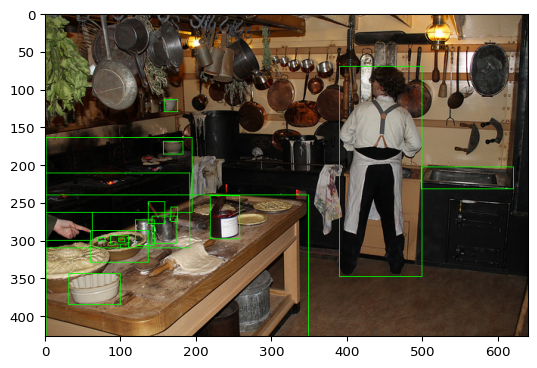

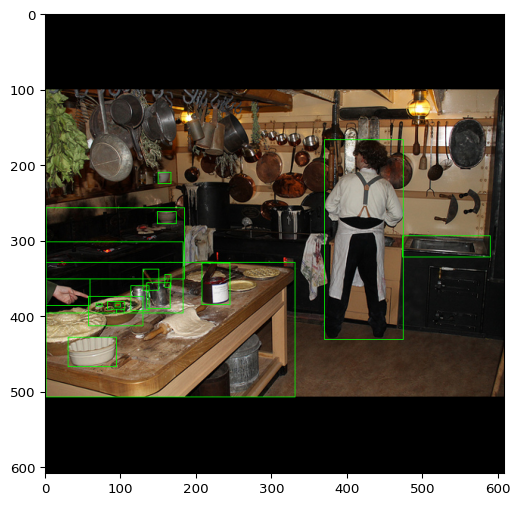

In [32]:
# import torch
from torchvision import datasets, models, transforms

# # mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

# preprocess_augment = transforms.Compose([
#     transforms.Resize(608),
#     # transforms.RandomCrop(224),
#     # transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)])

# preprocess = transforms.Compose([
#     transforms.Resize(608),
#     # transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean, std)])

# def resize_boxes(boxes, original_size, new_size):
#     # type: (Tensor, List[int], List[int]) -> Tensor
#     ratios = [
#         torch.tensor(s, dtype=torch.float32, device=boxes.device) /
#         torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
#         for s, s_orig in zip(new_size, original_size)
#     ]
#     ratio_height, ratio_width = ratios
#     xmin, ymin, xmax, ymax = boxes.unbind(1)

#     xmin = xmin * ratio_width
#     xmax = xmax * ratio_width
#     ymin = ymin * ratio_height
#     ymax = ymax * ratio_height
#     return torch.stack((xmin, ymin, xmax, ymax), dim=1)

# def target_transform(targets):
#     # print(labels[0]['bbox'])
#     # preprocess = transforms.Compose([
#     #     transforms.Resize(608),
#     #     # transforms.CenterCrop(224),
#     #     transforms.ToTensor(),
#     #     transforms.Normalize(mean, std)])

#     for i, target in enumerate(targets):
#         print(targets[i]['bbox'])
#         targets[i]['bbox'] = preprocess(targets[i]['bbox'])

from imgaug import augmenters as iaa 
import imgaug as ia
ia.seed(1)

seq = iaa.Sequential([
    iaa.Resize({"longer-side": 608, "shorter-side": "keep-aspect-ratio"}),
    iaa.CenterPadToSquare()
])

from PIL import Image
import os
import os.path
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import numpy as np
img_id = ids[0]
ann_ids = coco.getAnnIds(imgIds=img_id)
target = coco.loadAnns(ann_ids)
path = coco.loadImgs(img_id)[0]['file_name']
img = Image.open(os.path.join(root, path)).convert('RGB')
# t = transforms.Compose([transforms.ToTensor()])
# img = t(img)
img = np.array(img)
boxes = list()
for i in target:
    x,y,w,h = i['bbox']
    # print(x,y,w,h)
    x1,y1 = x,y
    x2,y2 = x+w,y+h

    boxes.append(BoundingBox(x1=x1,y1=y1,x2=x2,y2=y2))

print(img.shape)
boxes = BoundingBoxesOnImage(boxes, shape=img.shape)

img_aug, boxes_aug = seq(image=img, bounding_boxes=boxes)
# img = preprocess(img)
# target = target_transform(target)

ia.imshow(boxes.draw_on_image(img))

ia.imshow(boxes_aug.draw_on_image(img_aug))